In [1]:
import math
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, TensorDataset

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [2]:
from google.colab import drive
drive.mount('/content/drive')

data = pd.read_csv('/content/drive/MyDrive/2025_1_Colab/DeepLearning/Lib/stock.csv')

Mounted at /content/drive


In [3]:
features = ['Open', 'High', 'Low']

X = data.loc[:, features]

Y = data[['Close']]

In [4]:
# MinMax scaler

X_max = X.max()
Y_max = Y.max()

X_min = X.min()
Y_min = Y.min()

X_s = (X - X_min) / (X_max - X_min)
Y_s = (Y - Y_min) / (Y_max - Y_min)

In [5]:
window_size = 30

def make_dataset(x_data, y_data, window_size):
    x_list = []
    y_list = []

    for i in range(len(x_data) - window_size):
        x_list.append(np.array(x_data.iloc[i:i + window_size]))
        y_list.append(np.array(y_data.iloc[i + window_size]))

    x_list = torch.Tensor(np.array(x_list))
    y_list = torch.Tensor(np.array(y_list))

    return torch.Tensor(x_list), torch.Tensor(y_list).squeeze(-1)

X_w, Y_w = make_dataset(X_s, Y_s, window_size)

In [6]:
train_num = 700
X_train = X_w[:train_num].to(device)
X_test = X_w[train_num:].to(device)

y_train = Y_w[:train_num].to(device)
y_test = Y_w[train_num:].to(device)

In [7]:
train_dataset = TensorDataset(X_train, y_train)

train_loader = DataLoader(train_dataset, batch_size = 32)

for x_data, y_data in train_loader:
    break

print(x_data.shape)
print(y_data.shape)

torch.Size([32, 30, 3])
torch.Size([32])


In [ ]:
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()

        self.rnn = nn.RNN(input_size = len(features), hidden_size = 8, num_layers = 5, batch_first = True)
        self.fc1 = nn.Linear(in_features = window_size * 8, out_features = 64)
        self.fc2 = nn.Linear(in_features = 64, out_features = 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        h0 = torch.zeros(5, x.shape[0], 8).to(device)
        x, hn = self.rnn(x, h0)

        x = x.reshape(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = x.squeeze(-1)

        return x

In [ ]:
# 난수 고정
torch.cuda.manual_seed(123)

input_size = len(features)
hidden_size = 8
num_layers = 5
model = RNN()
model.to(device)
lr = 0.00005
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

loss_history_train=[]
loss_history_test=[]

In [ ]:
num_epochs = 2000
for epoch in range(num_epochs):

    for x_data, y_data in train_loader:
        optimizer.zero_grad()

        outputs = model(x_data)
        loss_train = nn.MSELoss()(outputs, y_data)

        loss_train.backward()
        optimizer.step()

    outputs_train = model(X_train)
    loss_train = nn.MSELoss()(outputs_train, y_train)

    outputs_test = model(X_test)
    loss_test = nn.MSELoss()(outputs_test, y_test)

    loss_history_train.append(loss_train.item())
    loss_history_test.append(loss_test.item())
    if epoch % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], loss: {loss_train: .5f}, loss_test: {loss_test:.5f}')

Epoch [1/2000], loss:  0.12157, loss_test: 0.35868
Epoch [101/2000], loss:  0.00222, loss_test: 0.00675
Epoch [201/2000], loss:  0.00178, loss_test: 0.00543
Epoch [301/2000], loss:  0.00139, loss_test: 0.00414
Epoch [401/2000], loss:  0.00118, loss_test: 0.00338
Epoch [501/2000], loss:  0.00109, loss_test: 0.00312
Epoch [601/2000], loss:  0.00102, loss_test: 0.00291
Epoch [701/2000], loss:  0.00097, loss_test: 0.00273
Epoch [801/2000], loss:  0.00088, loss_test: 0.00249
Epoch [901/2000], loss:  0.00085, loss_test: 0.00229
Epoch [1001/2000], loss:  0.00081, loss_test: 0.00210
Epoch [1101/2000], loss:  0.00078, loss_test: 0.00194
Epoch [1201/2000], loss:  0.00074, loss_test: 0.00180
Epoch [1301/2000], loss:  0.00072, loss_test: 0.00168
Epoch [1401/2000], loss:  0.00070, loss_test: 0.00158
Epoch [1501/2000], loss:  0.00069, loss_test: 0.00150
Epoch [1601/2000], loss:  0.00067, loss_test: 0.00142
Epoch [1701/2000], loss:  0.00065, loss_test: 0.00136
Epoch [1801/2000], loss:  0.00064, loss_

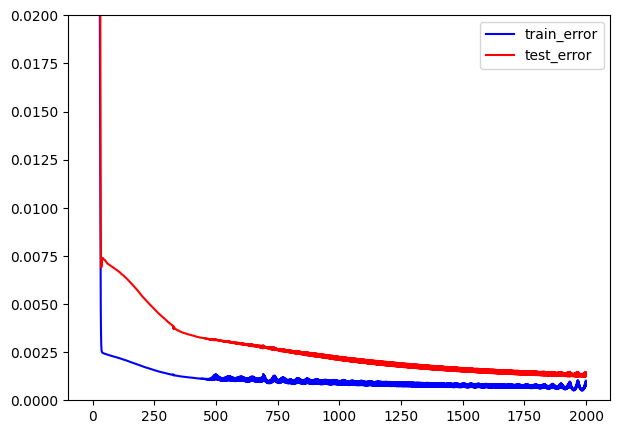

In [ ]:
plt.figure(figsize = (7,5))
plt.plot(loss_history_train, 'b', label = 'train_error')
plt.plot(loss_history_test, 'r', label = 'test_error')
plt.ylim([0, 0.02])
plt.legend()
plt.show()

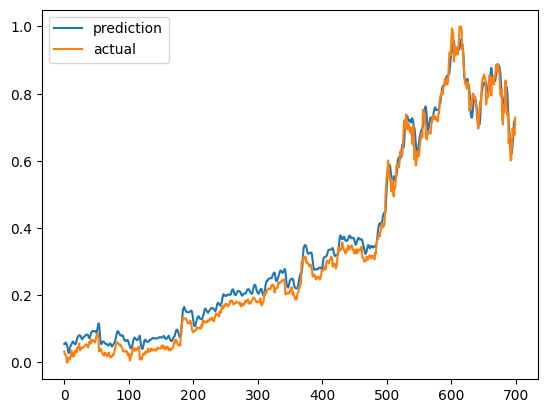

In [ ]:
plt.plot(outputs_train.to('cpu').detach(), label='prediction')
plt.plot(y_train.to('cpu'), label = 'actual')
plt.legend()
plt.show()

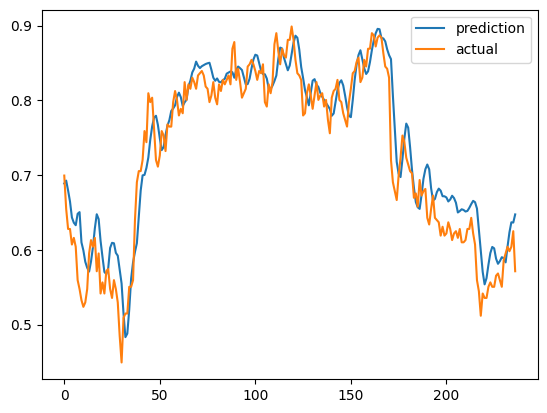

In [ ]:
plt.plot(outputs_test.to('cpu').detach(), label = 'prediction')
plt.plot(y_test.to('cpu'), label = 'actual')
plt.legend()
plt.show()

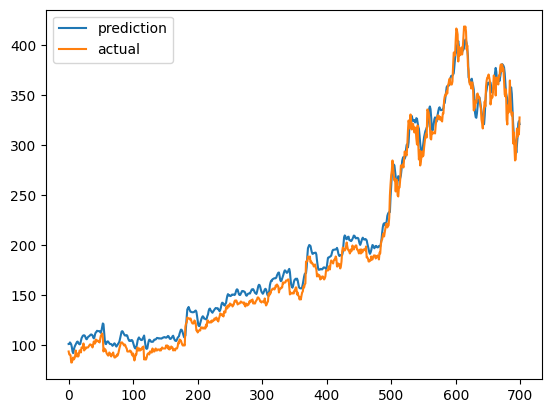

In [ ]:
plt.plot(torch.Tensor([Y_max.item() - Y_min.item()]) * outputs_train.to('cpu').detach() + torch.Tensor([Y_min.item()]), label = 'prediction')
plt.plot(torch.Tensor([Y_max.item() - Y_min.item()]) * y_train.to('cpu') + torch.Tensor([Y_min.item()]), label = 'actual')
plt.legend()
plt.show()


In [8]:
class LSTM(nn.Module):
  def __init__(self):
    super(LSTM, self).__init__()

    self.lstm = nn.LSTM(input_size = len(features), hidden_size = 8, num_layers=5, batch_first = True)

    self.fc1 = nn.Linear(in_features=window_size*8, out_features=64)
    self.fc2 = nn.Linear(in_features=64, out_features=1)
    self.relu = nn.ReLU()

  def forward(self, x):
    h0 = torch.zeros(5, x.shape[0], 8).to(device)
    c0 = torch.zeros(5, x.shape[0], 8).to(device) # 초기 cell gate 추가 설정

    x, hn = self.lstm(x, (h0, c0))

    x = x.reshape(x.size(0), -1)

    x = self.fc1(x)
    x = self.relu(x)
    x = self.fc2(x)

    x = x.reshape(-1)

    return x

In [9]:
# 난수 고정
torch.cuda.manual_seed(123)

model_L = LSTM()
model_L.to(device)
lr = 0.0001
optimizer_L = torch.optim.Adam(model_L.parameters(), lr=lr)

loss_history_train_L=[]
loss_history_test_L=[]

In [10]:
num_epochs = 2000
for epoch in range(num_epochs):

    for x_data, y_data in train_loader:
        optimizer_L.zero_grad()

        outputs = model_L(x_data)
        loss_train = nn.MSELoss()(outputs, y_data)

        loss_train.backward()
        optimizer_L.step()

    outputs_train = model_L(X_train)
    loss_train = nn.MSELoss()(outputs_train, y_train)

    outputs_test = model_L(X_test)
    loss_test = nn.MSELoss()(outputs_test, y_test)

    loss_history_train_L.append(loss_train.item())
    loss_history_test_L.append(loss_test.item())
    if epoch % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], loss: {loss_train: .5f}, loss_test: {loss_test:.5f}')

Epoch [1/2000], loss:  0.11792, loss_test: 0.34748
Epoch [101/2000], loss:  0.00431, loss_test: 0.01398
Epoch [201/2000], loss:  0.00299, loss_test: 0.01103
Epoch [301/2000], loss:  0.00270, loss_test: 0.00932
Epoch [401/2000], loss:  0.00253, loss_test: 0.00819
Epoch [501/2000], loss:  0.00237, loss_test: 0.00731
Epoch [601/2000], loss:  0.00223, loss_test: 0.00652
Epoch [701/2000], loss:  0.00209, loss_test: 0.00579
Epoch [801/2000], loss:  0.00196, loss_test: 0.00510
Epoch [901/2000], loss:  0.00184, loss_test: 0.00450
Epoch [1001/2000], loss:  0.00173, loss_test: 0.00403
Epoch [1101/2000], loss:  0.00161, loss_test: 0.00370
Epoch [1201/2000], loss:  0.00150, loss_test: 0.00351
Epoch [1301/2000], loss:  0.00142, loss_test: 0.00344
Epoch [1401/2000], loss:  0.00135, loss_test: 0.00340
Epoch [1501/2000], loss:  0.00128, loss_test: 0.00333
Epoch [1601/2000], loss:  0.00123, loss_test: 0.00325
Epoch [1701/2000], loss:  0.00114, loss_test: 0.00305
Epoch [1801/2000], loss:  0.00111, loss_

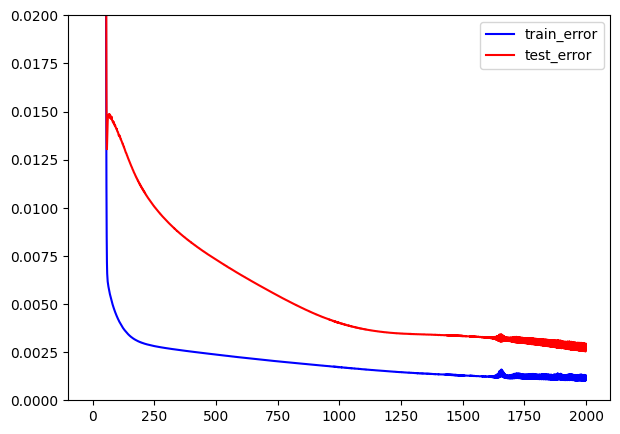

In [12]:
plt.figure(figsize = (7,5))
plt.plot(loss_history_train_L, 'b', label = 'train_error')
plt.plot(loss_history_test_L, 'r', label = 'test_error')
plt.ylim([0, 0.02])
plt.legend()
plt.show()

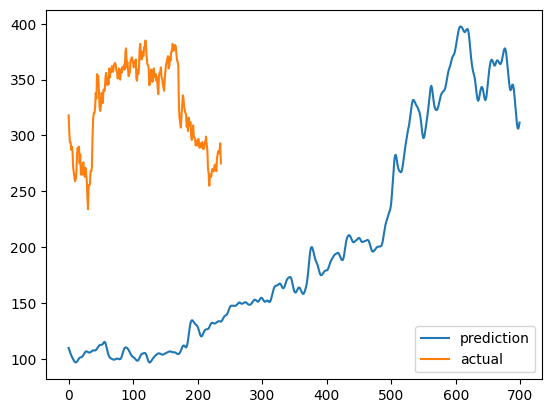

In [16]:
plt.plot(torch.Tensor([Y_max.item() - Y_min.item()]) * outputs_train.to('cpu').detach() + torch.Tensor([Y_min.item()]), label = 'prediction')
plt.plot(torch.Tensor([Y_max.item() - Y_min.item()]) * y_test.to('cpu') + torch.Tensor([Y_min.item()]), label = 'actual')
plt.legend()
plt.show()

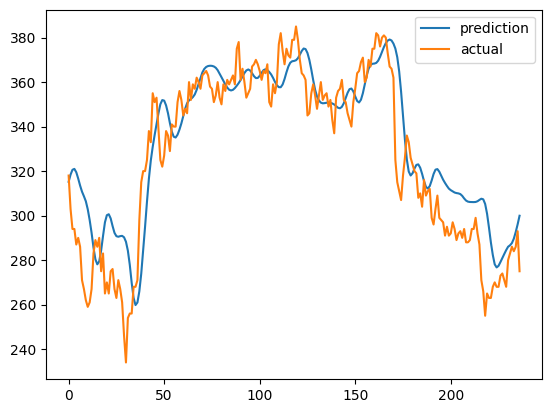

In [17]:
plt.plot(torch.Tensor([Y_max.item() - Y_min.item()]) * outputs_test.to('cpu').detach() + torch.Tensor([Y_min.item()]), label = 'prediction')
plt.plot(torch.Tensor([Y_max.item() - Y_min.item()]) * y_test.to('cpu') + torch.Tensor([Y_min.item()]), label = 'actual')
plt.legend()
plt.show()

### LSTM을 피해야 할 조건
|조건 | 설명|
|-----|---|
|데이터가 짧은 시퀀스 | 예: 시계열이 짧고 시간 의존성이 약하면 굳이 LSTM의 복잡성이 필요없음|
|데이터가 단순함|LSTM의 gate 구조가 오히려 과적합(overfitting) 될 수 있음|
|모델이 작아야 할 때|RNN은 계산이 훨씬 빠르고, 파라미터 수도 적음|
|학습 데이터 부족|복잡한 구조보다 단순한 RNN이 더 안정적으로 작동할 수 있음|
|실시간 또는 임베디드 환경|계산 자원이 부족한 환경에선 RNN이 더 적합|
